# ECG/Resp Inspection
Processes ECG data (from files or from ICE parameters in the TWIX file) and displays time-domain plots with optionally detected events (R-peaks). Also plots respiratory signals and detects peaks/troughs for respiration.

### Loading packages and data

In [27]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import utils.data_ingestion as di
import utils.ecg_resp as ecg_resp
import scipy.signal as signal
# %matplotlib widget

def load_config(config_file="config.yaml"):
    """
    Load configuration from a YAML file.

    Parameters
    ----------
    config_file : str
        Path to the YAML configuration file.

    Returns
    -------
    dict
        Parsed configuration.
    """
    with open(config_file, "r") as f:
        return yaml.safe_load(f)

# Read config
config = load_config()

# Paths and optional file references
twix_file = config["data"]["twix_file"]
dicom_folder = config["data"]["dicom_folder"]
ecg_files = config["data"].get("ecg_files", None)
event_file = config["data"].get("event_file", None)
resp_file = config["data"].get("resp_file", None)

# Read TWIX, extract raw k-space, and derive sampling frequency
scans = di.read_twix_file(twix_file, include_scans=[-1], parse_pmu=False)

Software version: VD/VE (!?)

Scan  1


100%|██████████| 287M/287M [00:00<00:00, 2.36GB/s]

Read 1 scans from 20250307_JM/raw/meas_MID00115_FID27380_Cor_250306_2.dat


### Extracting and analyzing ECG

In [28]:
# first_time = None
# last_time = None
# for (i,mdb) in enumerate(scans[-1]['mdb']):
#     if mdb.is_image_scan():
#         print(mdb.mdh.TimeStamp)
#         last_time = mdb.mdh.TimeStamp
#         if first_time is None:
#             first_time = mdb.mdh.TimeStamp

# print("First time: ", first_time)
# print("Last time: ", last_time)
# print("Time difference: ", (last_time - first_time) * 2.5e-3)

In [29]:
kspace = di.extract_image_data(scans)

framerate, frametime = di.get_dicom_framerate(dicom_folder)
n_phase_encodes_per_frame = kspace.shape[0] // config["data"]["n_frames"]
fs = framerate * n_phase_encodes_per_frame  # ECG / respiration sampling freq
# fs = 1/(scans[-1]['hdr']['Phoenix']['alTR'][0]/1000/48/1000)

# Load ECG data either from external files or from the ICE parameters
if ecg_files:
    # Concatenate multi-file ECG data channel-wise
    ecg_data = []
    for ecg_file in ecg_files:
        raw_ecg = np.loadtxt(ecg_file, skiprows=1, usecols=1)
        ecg_data.append(signal.resample(raw_ecg, kspace.shape[0]))
    ecg_data = np.vstack(ecg_data).T
else:
    ecg_columns = np.s_[18:21]
    ecg_data = di.extract_iceparam_data(scans, segment_index=0, columns=ecg_columns)
    # Force 2D shape
    if ecg_data.ndim == 1:
        ecg_data = ecg_data.reshape(-1, 1)

Extracted image data shape: (4800, 30, 256)


In [30]:
# Example (commented) R-peak detection
# r_peaks_list = ecg_resp.detect_r_peaks(ecg_data, fs)
# hr = ecg_resp.compute_average_heart_rate(r_peaks_list, fs)
# print(f"Average heart rate: {hr:.2f} BPM")

# If event_file is present, interpret it as R-peak triggers or some other event
if event_file:
    resampled_length = kspace.shape[0]
    raw_events = np.loadtxt(event_file, skiprows=1, usecols=1)
    # Normalize events so that non-zero remain as spikes
    raw_events = raw_events - np.min(raw_events)
    raw_length = len(raw_events)

    # Create empty, then place spikes based on global fraction
    resampled_events = np.zeros(resampled_length)
    raw_spike_indices = np.nonzero(raw_events)[0]
    resampled_spike_indices = np.round(
        raw_spike_indices / (raw_length - 1) * (resampled_length - 1)
    ).astype(int)

    for (raw_idx, resampled_idx) in zip(raw_spike_indices, resampled_spike_indices):
        resampled_events[resampled_idx] = raw_events[raw_idx]
else:
    resampled_events = None

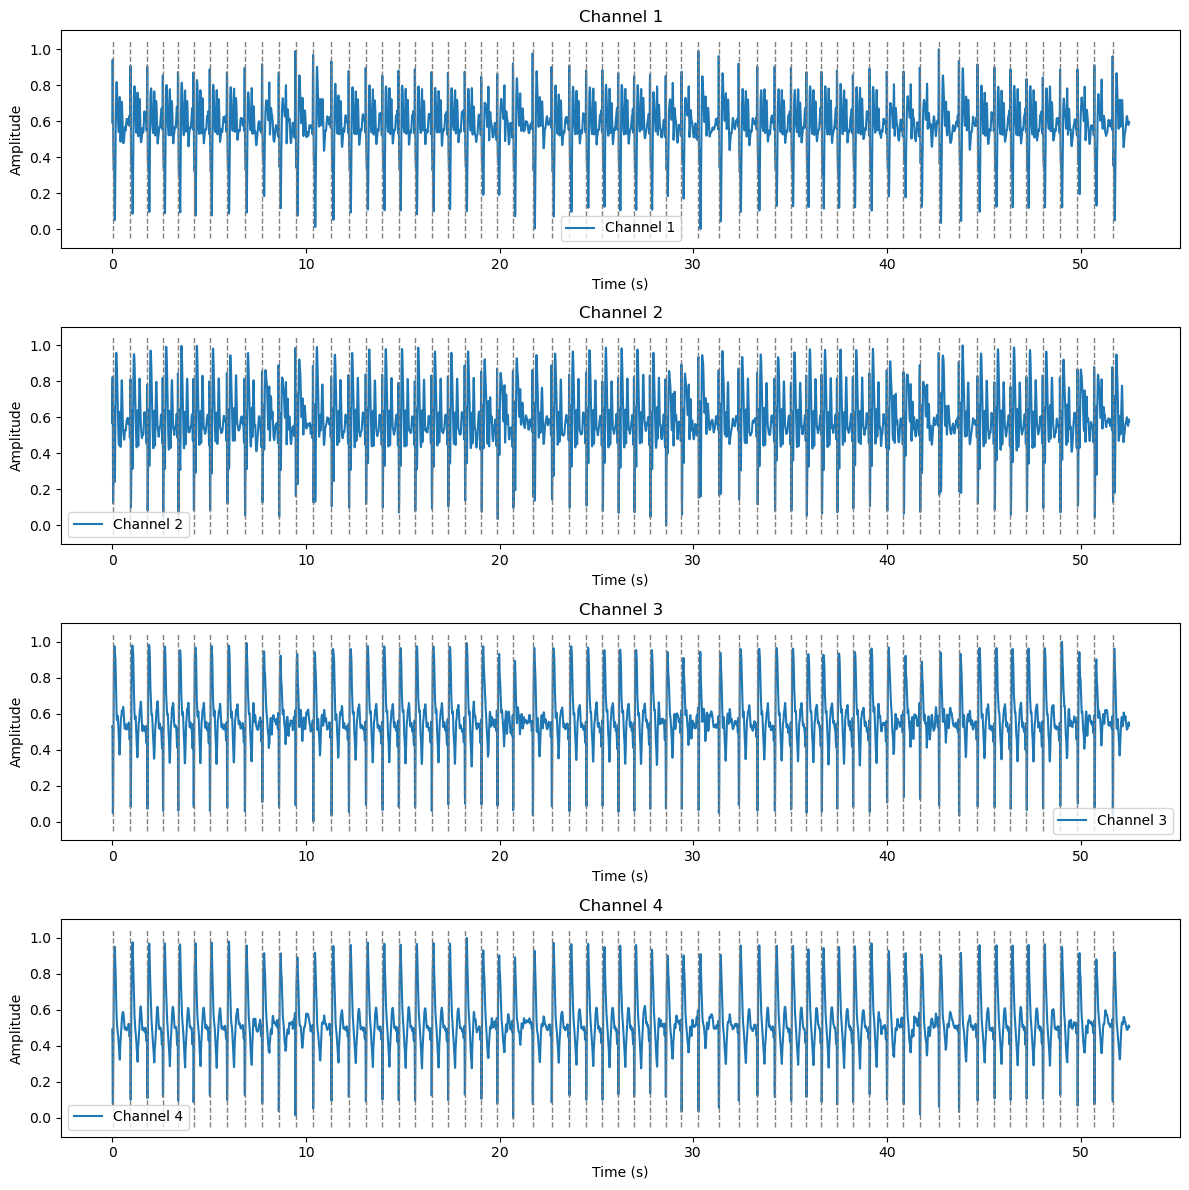

In [31]:
# Normalize ECG
ecg_data = (ecg_data - np.min(ecg_data, axis=0)) / (
    np.ptp(ecg_data, axis=0) + 1e-9
)

# Plot ECG with optional event spikes as vertical lines
ecg_resp.plot_ecg_signals(ecg_data, fs, spike_indices=np.nonzero(resampled_events)[0] if resampled_events is not None else None, mode="separate")

### Extracting and analyzing resp

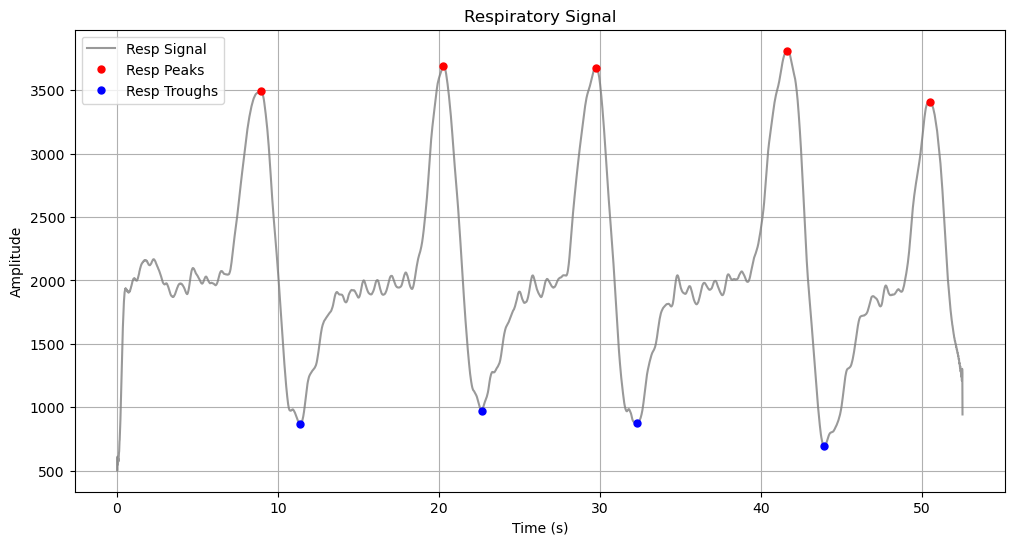

In [32]:
# If a respiratory file is present, load and detect peaks/troughs
if resp_file:
    resp_data = np.loadtxt(resp_file, skiprows=1, usecols=1)
    # Resample to match the total number of k-space time points
    resp_data = signal.resample(resp_data, kspace.shape[0])[:, np.newaxis]

    resp_peaks = ecg_resp.detect_resp_peaks(resp_data, fs, method='scipy', height=0.6, prominence=0.2)
    resp_troughs = ecg_resp.detect_resp_peaks(-resp_data, fs, method='scipy', height=0.6, prominence=0.2)

    # Plot
    ecg_resp.plot_resp_signal(resp_data, fs, resp_peaks=resp_peaks, resp_troughs=resp_troughs)

In [ ]:
# TODO: Make peak/trough detection faster in real-time (i.e., it shouold be more reactive since it seems to pick up on regime changes quite late)
# there is relatively little noise at the peaks/troughs, so some basic smoothing + peak detection / derivative-based peak detection should be sufficient

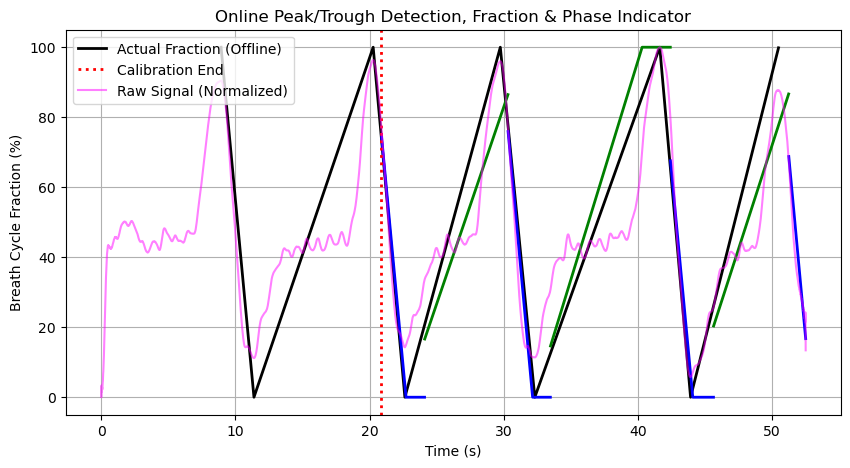

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# We'll use your existing detection function from utils.ecg_resp:
from utils.ecg_resp import detect_resp_peaks

# Flatten the respiration signal
resp_signal = resp_data.flatten()
N = len(resp_signal)

# Sampling frequency from your notebook
# fs = ...  # Must already be defined

# -------------------------------------------------------------------------
# Helper function: given sorted boundaries + labels, find all full cycles
# Each cycle is either:
#   trough -> peak   (inhalation)
#   peak   -> trough (exhalation)
# We collect durations, e.g. (start_idx, end_idx, 'inhalation'/'exhalation').
# -------------------------------------------------------------------------
def extract_cycles(boundary_indices, boundary_labels):
    """
    boundary_indices : np.ndarray of sorted boundary indices
    boundary_labels  : array of same length, each label is 'peak' or 'trough'
    Returns: list of (start_idx, end_idx, 'inhalation' or 'exhalation')
    """
    cycles = []
    for i in range(len(boundary_indices) - 1):
        s_idx = boundary_indices[i]
        e_idx = boundary_indices[i+1]
        s_lab = boundary_labels[i]
        e_lab = boundary_labels[i+1]
        if s_lab == 'trough' and e_lab == 'peak':
            cycles.append((s_idx, e_idx, 'inhalation'))
        elif s_lab == 'peak' and e_lab == 'trough':
            cycles.append((s_idx, e_idx, 'exhalation'))
    return cycles

# -------------------------------------------------------------------------
# Helper function: from cycles, compute average inhalation & exhalation durations (in seconds).
# -------------------------------------------------------------------------
def compute_avg_durations(cycles, fs):
    inhalation_lengths = []
    exhalation_lengths = []
    for (start_i, end_i, phase) in cycles:
        if end_i > start_i:  
            duration_sec = (end_i - start_i)/fs
            if phase == 'inhalation':
                inhalation_lengths.append(duration_sec)
            else:
                exhalation_lengths.append(duration_sec)
    avg_inhale = np.mean(inhalation_lengths) if len(inhalation_lengths) > 0 else None
    avg_exhale = np.mean(exhalation_lengths) if len(exhalation_lengths) > 0 else None
    return avg_inhale, avg_exhale

# -------------------------------------------------------------------------
# Helper to figure out if we have at least 2 "full cycles"
# The user wants e.g. peak->trough->peak->trough->peak or trough->peak->trough->peak->trough
# effectively: we want at least 5 boundaries in alternating pattern (or 4 transitions).
# But simpler: if we have at least 2 cycles in `cycles` => done.
# -------------------------------------------------------------------------
def have_two_full_cycles(cycles):
    return len(cycles) >= 2

# -------------------------------------------------------------------------
# Build an "actual fraction" array purely for final plotting
# (In real time you wouldn't have this. It's just to visualize accuracy.)
# -------------------------------------------------------------------------
def build_true_fraction(signal_length, all_peaks, all_troughs):
    # Combine and sort
    all_extrema = np.concatenate((all_peaks, all_troughs))
    if len(all_extrema) == 0:
        return np.full(signal_length, np.nan)
    sort_idx = np.argsort(all_extrema)
    sorted_bdry = all_extrema[sort_idx]
    labels = []
    for b in sorted_bdry:
        if b in all_peaks:
            labels.append('peak')
        else:
            labels.append('trough')
    labels = np.array(labels, dtype=object)
    
    # Extract cycles
    cyc = extract_cycles(sorted_bdry, labels)
    actual_frac = np.full(signal_length, np.nan)
    for (si, ei, ph) in cyc:
        if ei <= si: 
            continue
        length = ei - si
        for x in range(si, min(ei, signal_length)):
            if ph == 'inhalation':
                # For inhalation: ramp up from 0 at trough to 100 at peak.
                frac = 100.0 * (x - si) / float(length)
            elif ph == 'exhalation':
                # For exhalation: ramp down from 100 at peak to 0 at trough.
                frac = 100.0 * (1.0 - (x - si) / float(length))
            else:
                frac = np.nan
            actual_frac[x] = frac
    return actual_frac


# Build offline "actual_fraction" from all final data. This is just for plotting.
actual_fraction = build_true_fraction(N, resp_peaks, resp_troughs)

# We'll store predicted fraction for each sample
predicted_fraction = np.full(N, np.nan)
# NEW: Also store a phase indicator (True for inhalation, False for exhalation)
predicted_phase = np.full(N, None)

calibration_done = False
calibration_end_idx = None

# For the last boundary logic:
last_boundary_idx = None   # The index of last peak/trough
last_boundary_label = None # 'peak' or 'trough'

avg_inhale = None
avg_exhale = None

# ---------------------------------------------------------
# MAIN TIME-STEP LOOP
# ---------------------------------------------------------
for k in range(N):
    # 1) One step forward: partial_data = up to index k
    partial_data = resp_signal[:k+1]

    # 2) Detect peaks/troughs on partial_data
    partial_peaks = detect_resp_peaks(partial_data, fs, method='scipy', height=0.6, prominence=0.2)
    partial_troughs = detect_resp_peaks(-partial_data, fs, method='scipy', height=0.6, prominence=0.2)

    # Label them
    # Combine and sort
    boundaries = np.concatenate((partial_peaks, partial_troughs))
    sort_idx = np.argsort(boundaries)
    boundaries = boundaries[sort_idx]
    labels = []
    for b in boundaries:
        labels.append('peak' if b in partial_peaks else 'trough')
    labels = np.array(labels, dtype=object)

    # 3) Build the cycles from these boundaries
    cycles = extract_cycles(boundaries, labels)

    # 4) Check if we have at least 2 cycles => calibration done
    if (not calibration_done) and have_two_full_cycles(cycles) and k / fs > 10:
        calibration_done = True
        calibration_end_idx = k  # we say calibration ended at sample k

    if not calibration_done:
        # If not calibrated, skip prediction
        predicted_fraction[k] = np.nan
        predicted_phase[k] = None
        continue

    # If we are here => calibration is done => we can predict
    # 5) Recompute average inhale/exhale from *all* cycles so far
    new_avg_inhale, new_avg_exhale = compute_avg_durations(cycles, fs)
    # We'll keep them if they exist, otherwise fallback to old
    if new_avg_inhale is not None:
        avg_inhale = new_avg_inhale
    if new_avg_exhale is not None:
        avg_exhale = new_avg_exhale

    # If still None, we can't predict
    if (avg_inhale is None) or (avg_exhale is None):
        predicted_fraction[k] = np.nan
        predicted_phase[k] = None
        continue

    # 6) Identify the most recent boundary in partial_data
    if len(boundaries) == 0:
        # no boundaries => can't do anything
        predicted_fraction[k] = np.nan
        predicted_phase[k] = None
        continue
    else:
        last_boundary_idx = boundaries[-1]
        last_boundary_label = labels[-1]  # 'peak' or 'trough'

    # NEW: Set the phase indicator based on the last boundary:
    # If last boundary is 'trough', we assume inhalation (True); if 'peak', exhalation (False).
    if last_boundary_label == 'trough':
        predicted_phase[k] = True   # Inhalation
    elif last_boundary_label == 'peak':
        predicted_phase[k] = False  # Exhalation
    else:
        predicted_phase[k] = None

    # If the last boundary is a trough => we are inhaling now
    # If the last boundary is a peak => we are exhaling
    # We'll linearly ramp from that boundary to boundary + avg_inhale or boundary + avg_exhale
    if last_boundary_label == 'trough':
        # Inhalation: phase fraction ramps from 0% at the trough to 100% at the peak.
        expected_end = last_boundary_idx + int(round(avg_inhale * fs))
        frac = 100.0 * (k - last_boundary_idx) / float(expected_end - last_boundary_idx)
    elif last_boundary_label == 'peak':
        # Exhalation: phase fraction ramps from 100% at the peak to 0% at the trough.
        expected_end = last_boundary_idx + int(round(avg_exhale * fs))
        frac = 100.0 * (1.0 - (k - last_boundary_idx) / float(expected_end - last_boundary_idx))
    else:
        frac = np.nan

    # Clamp fraction between 0 and 100.
    frac = max(0, min(100, frac))
    predicted_fraction[k] = frac


# ---------------------------------------------------------
# Plot results
# ---------------------------------------------------------
t = np.arange(N)/fs
plt.figure(figsize=(10,5))

# Plot the offline reference fraction (unchanged)
plt.plot(t, actual_fraction, label='Actual Fraction (Offline)', linewidth=2, color='black')

# Instead of a single line for predicted_fraction, we segment it by predicted_phase.
# We'll use green for inhalation (True), blue for exhalation (False), and gray if unknown.
start_idx = 0
for i in range(1, N):
    # If the phase indicator changes, plot the segment from start_idx to i-1.
    if predicted_phase[i] != predicted_phase[i-1]:
        seg_t = t[start_idx:i]
        seg_y = predicted_fraction[start_idx:i]
        if predicted_phase[i-1] is True:
            color = 'green'      # inhalation
        elif predicted_phase[i-1] is False:
            color = 'blue'       # exhalation
        else:
            color = 'gray'
        plt.plot(seg_t, seg_y, '-', color=color, linewidth=2)
        start_idx = i
# Plot the last segment
if start_idx < N:
    seg_t = t[start_idx:]
    seg_y = predicted_fraction[start_idx:]
    if predicted_phase[-1] is True:
        color = 'green'
    elif predicted_phase[-1] is False:
        color = 'blue'
    else:
        color = 'gray'
    plt.plot(seg_t, seg_y, '-', color=color, linewidth=2)

# Optionally, add a vertical line at calibration end
if calibration_end_idx is not None:
    plt.axvline(calibration_end_idx/fs, color='r', linestyle=':', linewidth=2, label='Calibration End')

# Normalize raw resp_signal to range 0-100
raw_norm = (resp_signal - np.min(resp_signal)) / (np.ptp(resp_signal)) * 100.0
plt.plot(t, raw_norm, label='Raw Signal (Normalized)', color='magenta', alpha=0.5)

plt.title("Online Peak/Trough Detection, Fraction & Phase Indicator")
plt.xlabel("Time (s)")
plt.ylabel("Breath Cycle Fraction (%)")
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

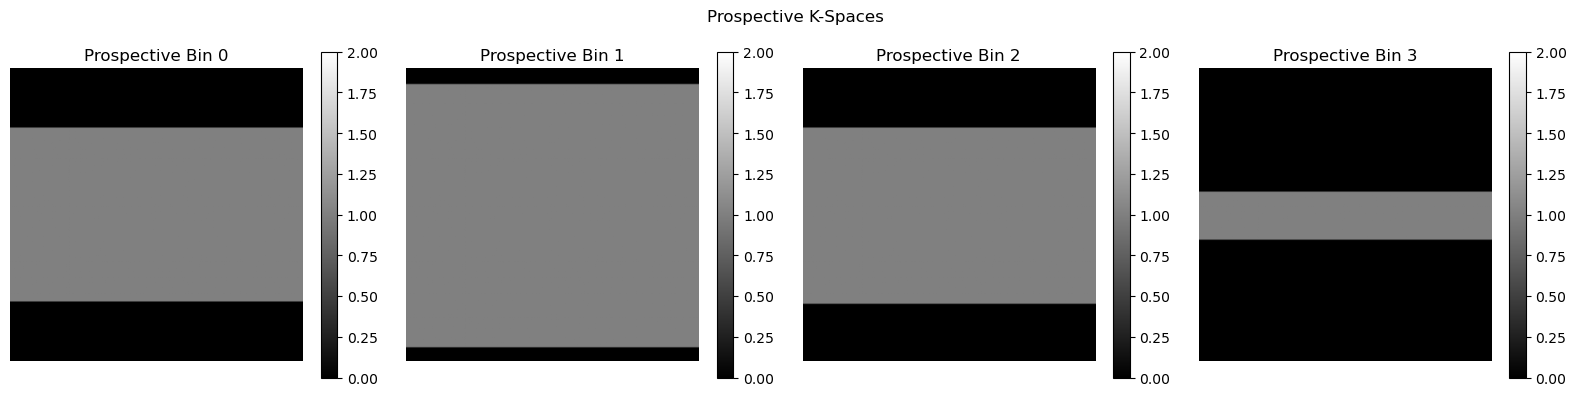

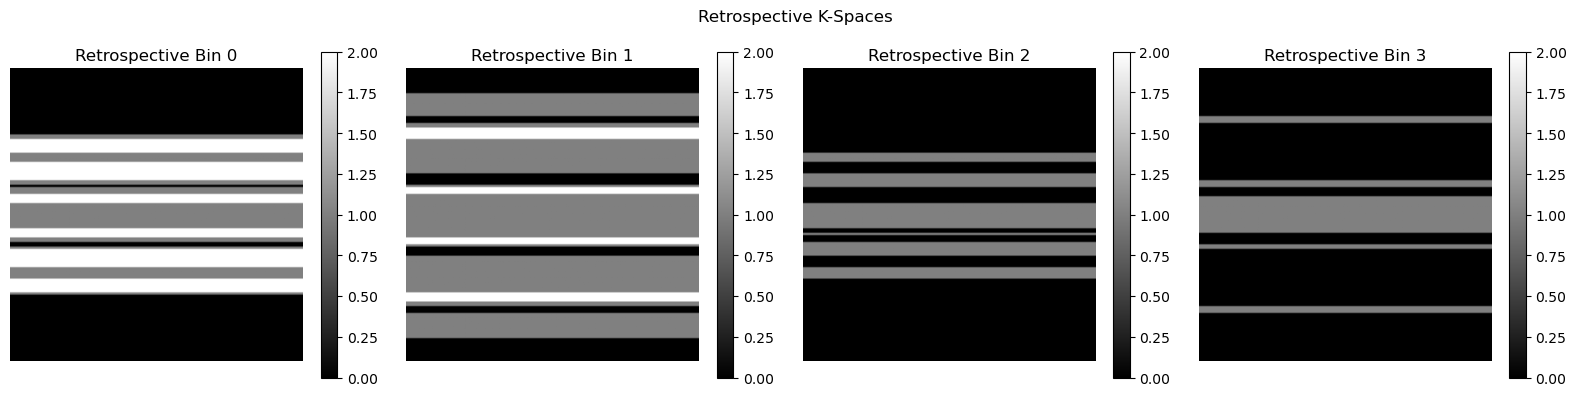

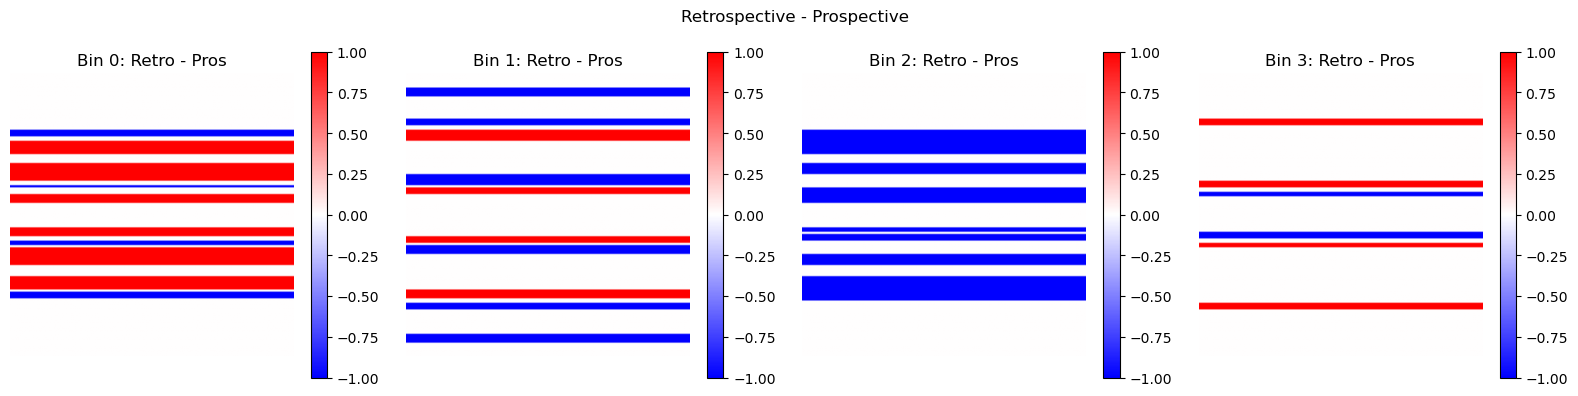

Confusion Matrix (Rows = Prospective Bin, Columns = Retrospective Bin):
           RetroBin_0  RetroBin_1  RetroBin_2  RetroBin_3
ProsBin_0          59          17           0           0
ProsBin_1           6          90           0          11
ProsBin_2          38           0          32           0
ProsBin_3           0           0           1          16


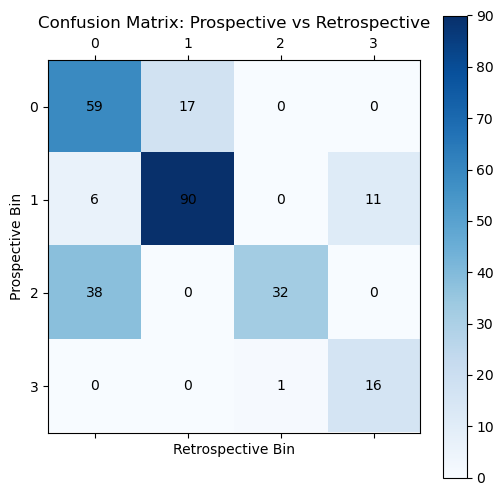

Prospective binning accuracy = 72.96%


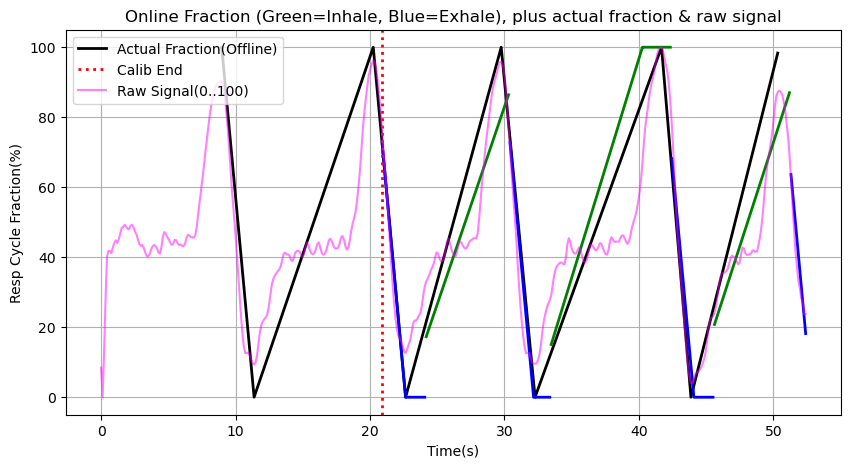

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# We'll use your existing detection function from utils.ecg_resp:
from utils.ecg_resp import detect_resp_peaks

############################################################################
# PART A: FRACTION + PHASE DETECTION
############################################################################

downsample_factor = 10

# Flatten the respiration signal
resp_signal = resp_data.flatten()
N = len(resp_signal)
fs = framerate * n_phase_encodes_per_frame  # ECG / respiration sampling freq

# Downsample the signal if needed
if downsample_factor > 1:
    resp_signal = signal.resample(resp_signal, N // downsample_factor)
    N = len(resp_signal)
    fs = fs / downsample_factor

def extract_cycles(boundary_indices, boundary_labels):
    cycles = []
    for i in range(len(boundary_indices) - 1):
        s_idx = boundary_indices[i]
        e_idx = boundary_indices[i+1]
        s_lab = boundary_labels[i]
        e_lab = boundary_labels[i+1]
        if s_lab == 'trough' and e_lab == 'peak':
            cycles.append((s_idx, e_idx, 'inhalation'))
        elif s_lab == 'peak' and e_lab == 'trough':
            cycles.append((s_idx, e_idx, 'exhalation'))
    return cycles

def compute_avg_durations(cycles, fs):
    inhalation_lengths = []
    exhalation_lengths = []
    for (start_i, end_i, phase) in cycles:
        if end_i>start_i:
            dur = (end_i - start_i)/fs
            if phase=='inhalation':
                inhalation_lengths.append(dur)
            else:
                exhalation_lengths.append(dur)
    avg_inh = np.mean(inhalation_lengths) if len(inhalation_lengths)>0 else None
    avg_exh = np.mean(exhalation_lengths) if len(exhalation_lengths)>0 else None
    return avg_inh, avg_exh

def have_two_full_cycles(cycles):
    return len(cycles)>=2

def build_true_fraction(signal_length, all_peaks, all_troughs):
    all_extrema = np.concatenate((all_peaks, all_troughs))
    if len(all_extrema)==0:
        return np.full(signal_length, np.nan)
    srt = np.sort(all_extrema)
    lbls = []
    for b_ in srt:
        if b_ in all_peaks:
            lbls.append('peak')
        else:
            lbls.append('trough')
    lbls = np.array(lbls, dtype=object)
    cyc = extract_cycles(srt, lbls)
    frac_arr = np.full(signal_length, np.nan)
    for (si, ei, ph) in cyc:
        if ei<=si:
            continue
        length = ei - si
        for x in range(si, min(ei, signal_length)):
            if ph=='inhalation':
                frac = 100.0*(x-si)/float(length)
            else:
                frac = 100.0*(1.0-(x-si)/float(length))
            frac_arr[x] = frac
    return frac_arr

# 1) Real-time predicted fraction / phase
predicted_fraction = np.full(N, np.nan)
predicted_phase = np.full(N, None)

calibration_done = False
calibration_end_idx = None
last_boundary_idx = None
last_boundary_label = None
avg_inhale = None
avg_exhale = None

for k in range(N):
    pd = resp_signal[:k+1]
    pks = detect_resp_peaks(pd, fs, method='scipy', height=0.6, prominence=0.2)
    trs = detect_resp_peaks(-pd, fs, method='scipy', height=0.6, prominence=0.2)
    bds = np.sort(np.concatenate((pks,trs)))
    lbs = []
    for b_ in bds:
        if b_ in pks:
            lbs.append('peak')
        else:
            lbs.append('trough')
    lbs = np.array(lbs, dtype=object)
    cyc = extract_cycles(bds, lbs)
    if (not calibration_done) and have_two_full_cycles(cyc) and (k/fs>10):
        calibration_done = True
        calibration_end_idx = k
    if not calibration_done:
        continue
    new_inh, new_exh = compute_avg_durations(cyc, fs)
    if new_inh is not None:
        avg_inhale = new_inh
    if new_exh is not None:
        avg_exhale = new_exh
    if (avg_inhale is None) or (avg_exhale is None):
        continue
    if len(bds)==0:
        continue
    last_boundary_idx = bds[-1]
    last_boundary_label = lbs[-1]
    if last_boundary_label=='trough':
        # inhalation
        predicted_phase[k] = True
        exp_end = last_boundary_idx + int(round(avg_inhale*fs))
        if exp_end>last_boundary_idx:
            frac = 100.0*(k-last_boundary_idx)/(exp_end-last_boundary_idx)
        else:
            frac=0
    else:
        predicted_phase[k] = False
        exp_end = last_boundary_idx + int(round(avg_exhale*fs))
        if exp_end>last_boundary_idx:
            frac = 100.0*(1.0 - (k-last_boundary_idx)/(exp_end-last_boundary_idx))
        else:
            frac=0
    frac = max(0, min(100, frac))
    predicted_fraction[k] = frac

############################################################################
# PART B: Binning & K-space with Weighted Votes
############################################################################
use_separate_in_ex_bins = True
num_inhale_bins = 2
num_exhale_bins = 2

use_total_bins_instead = False
num_total_bins = 4

KSPACE_H = 128
KSPACE_W = 128

def init_bin_arrays(count):
    return np.zeros((count, KSPACE_H, KSPACE_W), dtype=bool)

# Each bin has a dynamic priority array: priority[bin, row].
# We'll store them in a 2D array for each bin, then pick the highest row that isn't filled.
# We'll define a function to build that priority.
# We'll update it whenever we fill a line, so that if the conjugate is still unfilled, we get a bonus.

def build_bin_priorities(bin_count):
    # Return an array of shape (bin_count, 128), storing priority for each row
    # We'll define base priority = closeness to center row => e.g. 200 - abs(row-64)*2
    # We'll add "lack of symmetrical line" dynamically => for that we need to track fill status
    pr = np.zeros((bin_count, 128), dtype=float)
    center=64
    for b_i in range(bin_count):
        for r in range(128):
            dist = abs(r-center)
            base = 300 - dist*2
            pr[b_i, r] = base
    return pr

def update_priority_for_line_filled(bin_prior, bin_idx, row, fill_array):
    """
    fill_array is shape (bin_count,128,128). 
    For line= row, conjugate= 127 - row, we add a bonus or remove it if it's filled.
    We'll do a small function so that if row is now filled, the bin's priority for row is -inf,
    and if the conj row is not filled, we keep a bonus there, else remove bonus.
    """
    # set priority for row to negative => so we won't pick it again
    bin_prior[bin_idx, row] = -999999 # TODO: we might not want to make it -inf...since we don't want to prevent other bins from recording the line (maybe we should just set to 0)

    # TODO: We might not want to do based on conjSym row...we probably want to think more about this
    # we might want to think about prioritization based on GRAPPA or tGRAPPA

    # For the symmetrical row, let's define rowSym = 127-row
    # If rowSym is not filled, let's add some bonus to that row's priority
    rowSym = 127 - row
    if not fill_array[bin_idx, rowSym, 0]:  # if not filled => we do some small +20 bonus
        bin_prior[bin_idx, rowSym]+=20 # TODO: Do we want 20? Or a different number? Or maybe just a multiplier?
    else:
        # if it's filled => remove any potential bonus
        # We'll do a small check: 
        pass

def get_bin_index(fraction, is_inhale):
    """
    Return a dictionary {bin_idx: weight} using a Gaussian weighting around the bin's center fraction.
    The bin_count is determined by either separate in/ex or total approach.
    """
    if use_total_bins_instead:
        # single block of bins
        bin_count = num_total_bins
        bin_width= 100.0/bin_count
        bin_i = int(np.floor(fraction/bin_width))
        if bin_i>=bin_count: bin_i=bin_count-1
        bin_dict={}
        c_bin=(bin_i+0.5)*bin_width
        dist=abs(fraction-c_bin)
        sigma=bin_width*0.3
        w_main=np.exp(-0.5*(dist/sigma)**2)
        bin_dict[bin_i]=w_main
        for ac in [bin_i-1, bin_i+1]:
            if 0<=ac<bin_count:
                c2=(ac+0.5)*bin_width
                d2=abs(fraction-c2)
                w2=np.exp(-0.5*(d2/sigma)**2)
                if w2>1e-4: bin_dict[ac]=w2
        s=sum(bin_dict.values())
        if s<1e-8:
            bin_dict={bin_i:1.0}
        else:
            for b_ in bin_dict.keys():
                bin_dict[b_]=bin_dict[b_]/s
        return bin_dict
    else:
        # separate in/ex
        if is_inhale:
            bin_w= 100.0/num_inhale_bins
            bi=int(np.floor(fraction/bin_w))
            if bi>=num_inhale_bins: bi=num_inhale_bins-1
            bin_dict={}
            c_bin=(bi+0.5)*bin_w
            d=abs(fraction-c_bin)
            sig=bin_w*0.3
            w_m=np.exp(-0.5*(d/sig)**2)
            bin_dict[bi]=w_m
            for ac in [bi-1, bi+1]:
                if 0<=ac<num_inhale_bins:
                    c2=(ac+0.5)*bin_w
                    d2=abs(fraction-c2)
                    w2=np.exp(-0.5*(d2/sig)**2)
                    if w2>1e-4: bin_dict[ac]=w2
            s=sum(bin_dict.values())
            if s<1e-8:
                bin_dict={bi:1.0}
            else:
                for b_ in bin_dict.keys():
                    bin_dict[b_]=bin_dict[b_]/s
            return {b_:bin_dict[b_] for b_ in bin_dict.keys()}
        else:
            bin_w=100.0/num_exhale_bins
            bi=int(np.floor(fraction/bin_w))
            if bi>=num_exhale_bins: bi=num_exhale_bins-1
            bin_dict={}
            c_bin=(bi+0.5)*bin_w
            d=abs(fraction-c_bin)
            sig=bin_w*0.3
            w_m=np.exp(-0.5*(d/sig)**2)
            bin_dict[bi]=w_m
            for ac in [bi-1, bi+1]:
                if 0<=ac<num_exhale_bins:
                    c2=(ac+0.5)*bin_w
                    d2=abs(fraction-c2)
                    w2=np.exp(-0.5*(d2/sig)**2)
                    if w2>1e-4: bin_dict[ac]=w2
            s=sum(bin_dict.values())
            if s<1e-8:
                bin_dict={bi:1.0}
            else:
                for b_ in bin_dict.keys():
                    bin_dict[b_]=bin_dict[b_]/s
            # offset by num_inhale_bins
            dict_offset={}
            for b_ in bin_dict.keys():
                dict_offset[b_+num_inhale_bins]=bin_dict[b_]
            return dict_offset

def get_prospective_bin(fraction, is_inhale):
    """
    This is where we do a *hard assignment* based on fraction alone
    for prospective bin assignment. (No weighting from other bins.)
    """
    if use_total_bins_instead:
        bc=num_total_bins
        bw=100.0/bc
        b_i=int(np.floor(fraction/bw))
        if b_i>=bc:
            b_i=bc-1
        return b_i
    else:
        if is_inhale:
            bw=100.0/num_inhale_bins
            i_=int(np.floor(fraction/bw))
            if i_>=num_inhale_bins:
                i_=num_inhale_bins-1
            return i_
        else:
            bw=100.0/num_exhale_bins
            i_=int(np.floor(fraction/bw))
            if i_>=num_exhale_bins:
                i_=num_exhale_bins-1
            return i_+num_inhale_bins

def build_line_priority():
    """
    For each bin, an array of shape (128,) => priority. We'll do:
    basePriority = 300 - 2*|row-64|
    We'll add a dynamic bonus if the conjugate row is unfilled.
    Actually, we'll store base now, do dynamic bonus whenever we choose a line.
    """
    # We'll do shape (bin_count, 128).
    if use_total_bins_instead:
        bc=num_total_bins
    else:
        bc=num_inhale_bins+num_exhale_bins
    pr=np.zeros((bc,128), dtype=float)
    center=64
    for b_ in range(bc):
        for r in range(128):
            dist=abs(r-center)
            base=300 - dist*2
            pr[b_,r]=base
    return pr

def init_bin_arrays(bin_count):
    return np.zeros((bin_count, KSPACE_H, KSPACE_W), dtype=float)

def fill_line_in_bin(bin_idx, row, fill_array, priority_array):
    """
    fill_array[bin_idx, row, :] = True
    Then update priority => set that row to -9999 so we can't pick it again
    Also do a small check for symmetrical row => if it's not filled, +some bonus
    """
    fill_array[bin_idx, row, :] += 1.0
    priority_array[bin_idx, row] = -999999 # TODO: see above comment
    conj = 127-row
    if not fill_array[bin_idx, conj, 0]:  # if conj isn't filled
        priority_array[bin_idx, conj]+=20 # TODO: see above comment

############################################################################
# PART B1: Build structures for prospective and retrospective filling
############################################################################

if use_total_bins_instead:
    total_bins=num_total_bins
else:
    total_bins=num_inhale_bins+num_exhale_bins

pros_fill = init_bin_arrays(total_bins)
retro_fill= init_bin_arrays(total_bins)

pros_priority = build_line_priority() # shape (total_bins,128)
retro_priority= build_line_priority()

# We'll do a loop over time steps [0..N-1].
# Step 1: find the "vote" from each bin => bin_weight = get_bin_index(...)
# Step 2: for each bin, find the row with the highest priority that is unfilled => the "top row."
# Step 3: score = bin_weight * top_row_priority
# Step 4: pick the bin with max score => we fill that row in prospective sense in the bin determined by fraction
# Step 5: after we finish the entire time loop, we do the same for retrospective

############################################################################
# PART B2: PROSPECTIVE FILL
############################################################################

acquired_lines = [None]*N

for k in range(N):
    frac = predicted_fraction[k]
    if np.isnan(frac):
        continue
    ph = predicted_phase[k]
    if ph is None:
        continue

    # 1) compute bin_index => gaussian weighting => bin=>weight
    bin_weight = get_bin_index(frac, ph)

    # 2) for each bin, find the highest priority row that isn't filled => let's just do an argmax
    #    but we skip rows that are already filled => we can do a quick approach:
    #    priority we stored in pros_priority => but it's dynamic from fill_line_in_bin
    # we track: top_row[bin], top_priority[bin]
    top_candidates={}
    for b_ in range(total_bins):
        # skip if not in bin_weight
        # or weight is 0 => no point
        if b_ not in bin_weight.keys():
            continue
        w_ = bin_weight[b_]
        if w_<1e-6:
            continue
        row_argmax = np.argmax(pros_priority[b_])  # best row
        val = pros_priority[b_, row_argmax]
        if val<0:
            # means no lines left or everything filled
            continue
        score= w_*val
        top_candidates[b_] = (row_argmax, val, score)

    if len(top_candidates)==0:
        continue

    # 3) pick the bin with the highest "score"
    best_bin=None
    best_score=-999999
    best_row=None
    for b_ in top_candidates.keys():
        sc= top_candidates[b_][2]
        if sc>best_score:
            best_score=sc
            best_bin=b_
            best_row= top_candidates[b_][0]
    if best_bin is None:
        continue

    # 4) we fill that line into the "prospective bin" determined solely by fraction
    #    i.e. prospective_bin = get_prospective_bin(frac, ph)
    prospective_bin = get_prospective_bin(frac, ph)

    # Right after you pick "best_bin" and best_row:
    acquired_line = (best_row, prospective_bin)
    acquired_lines[k] = acquired_line

    # fill that row in pros_fill
    fill_line_in_bin(prospective_bin, best_row, pros_fill, pros_priority)

############################################################################
# PART B3: RETROSPECTIVE FILL
############################################################################

retro_fill = init_bin_arrays(total_bins)  # shape (bin_count,128,128) float

# Build the actual fraction
all_peaks = detect_resp_peaks(resp_signal, fs, method='scipy', height=0.6, prominence=0.2)
all_troughs = detect_resp_peaks(-resp_signal, fs, method='scipy', height=0.6, prominence=0.2)
actual_frac = build_true_fraction(N, all_peaks, all_troughs)

# after building actual_frac:
for k in range(N):
    if acquired_lines[k] is None:
        continue
    row, _pros_bin = acquired_lines[k]

    # figure out actual fraction
    frac = actual_frac[k]
    if np.isnan(frac):
        continue
    
    # decide inhalation/exhalation from fraction, or fallback
    if k>0 and not np.isnan(actual_frac[k-1]):
        is_inhale = (frac>=actual_frac[k-1])
    else:
        is_inhale = (frac<50)
    
    # find the "true" bin
    true_bin = get_prospective_bin(frac, is_inhale)

    # fill that line in the "retro_fill"
    retro_fill[true_bin, row, :] += 1.0

############################################################################
# PART C: VISUALIZATION
############################################################################

def plot_diff_map(pros, retro, title="Difference Map"):
    if pros.shape != retro.shape:
        print("Shape mismatch, skipping difference map.")
        return
    diff = retro - pros
    bin_count = diff.shape[0]
    cols = min(bin_count, 4)
    rows = int(np.ceil(bin_count / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    if rows == 1 and cols == 1:
        axs = np.array([axs])
    axs = axs.reshape(rows, cols)

    for b_ in range(bin_count):
        r_ = b_ // cols
        c_ = b_ % cols
        ax_ = axs[r_, c_]

        img = diff[b_]
        mm = np.abs(img).max()
        if mm < 1e-9:
            mm = 1
        im = ax_.imshow(img, cmap='bwr', vmin=-mm, vmax=mm)
        ax_.set_title(f"Bin {b_}: Retro - Pros")
        ax_.axis('off')

        # Optionally add an individual colorbar here:
        plt.colorbar(im, ax=ax_)

    # Or do one global colorbar:
    # fig.colorbar(im, ax=axs.ravel().tolist())

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()


def plot_kspace_bins(kspace_array, title_prefix, vmin=0, vmax=None):
    bin_count = kspace_array.shape[0]
    cols = min(bin_count, 4)
    rows = int(np.ceil(bin_count / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    if rows == 1 and cols == 1:
        axs = np.array([axs])
    axs = axs.reshape(rows, cols)

    # If no vmax given, fall back to max of the array
    if vmax is None:
        vmax = kspace_array.max()

    # We'll keep track of an imshow handle so we can add a colorbar
    im = None

    for b_ in range(bin_count):
        r_ = b_ // cols
        c_ = b_ % cols
        ax_ = axs[r_, c_]

        img = kspace_array[b_]
        im = ax_.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        # Optionally add a colorbar here:
        plt.colorbar(im, ax=ax_)
        ax_.set_title(f"{title_prefix} Bin {b_}")
        ax_.axis('off')

    # Turn off extra subplots if needed
    for i_ in range(bin_count, rows * cols):
        r_ = i_ // cols
        c_ = i_ % cols
        axs[r_, c_].axis('off')

    # # Single colorbar for this figure (optional)
    # if im is not None:
    #     fig.colorbar(im, ax=axs.ravel().tolist())

    fig.suptitle(f"{title_prefix} K-Spaces")
    fig.tight_layout()
    plt.show()


# Find a single global max across both prospective and retrospective k-space arrays:
global_max = max(pros_fill.max(), retro_fill.max())

# Then call your plotting functions, forcing them both to use vmin=0 and vmax=global_max
plot_kspace_bins(pros_fill, "Prospective", vmin=0, vmax=global_max)
plot_kspace_bins(retro_fill, "Retrospective", vmin=0, vmax=global_max)

plot_diff_map(pros_fill, retro_fill, title="Retrospective - Prospective")

confusion_mat = np.zeros((total_bins, total_bins), dtype=int)

for k in range(N):
    if acquired_lines[k] is None:
        continue
    row, p_bin = acquired_lines[k]
    frac = actual_frac[k]
    if np.isnan(frac):
        # can't define r_bin
        continue
    if k>0 and not np.isnan(actual_frac[k-1]):
        is_inhale = (frac>=actual_frac[k-1])
    else:
        is_inhale = (frac<50)
    r_bin = get_prospective_bin(frac, is_inhale)
    confusion_mat[p_bin, r_bin] += 1

import pandas as pd

# Suppose your confusion matrix is in 'confusion_mat'
# and 'total_bins' is the number of bins (rows = prospective, cols = retrospective).

row_labels = [f"ProsBin_{i}" for i in range(total_bins)]
col_labels = [f"RetroBin_{j}" for j in range(total_bins)]
df_conf = pd.DataFrame(confusion_mat, index=row_labels, columns=col_labels)

print("Confusion Matrix (Rows = Prospective Bin, Columns = Retrospective Bin):")
print(df_conf)

import numpy as np
import matplotlib.pyplot as plt

def show_confusion_matrix(conf_mat):
    fig, ax = plt.subplots(figsize=(6,6))

    # Display the matrix as an image
    cax = ax.matshow(conf_mat, cmap='Blues')
    
    # Optionally add a colorbar on the side
    fig.colorbar(cax)

    # Label the axes
    ax.set_xlabel("Retrospective Bin")
    ax.set_ylabel("Prospective Bin")

    # Make x,y ticks for each bin index
    total_bins = conf_mat.shape[0]
    ax.set_xticks(np.arange(total_bins))
    ax.set_yticks(np.arange(total_bins))

    # Optionally label each cell with the numeric value
    for i in range(total_bins):
        for j in range(total_bins):
            ax.text(j, i, str(conf_mat[i, j]),
                    va='center', ha='center', color='black')

    plt.title("Confusion Matrix: Prospective vs Retrospective")
    plt.show()

# Then simply call:
show_confusion_matrix(confusion_mat)


# Optionally compute e.g. an accuracy measure or any summary
correct_assignments = np.sum(np.diag(confusion_mat))
total_assignments  = np.sum(confusion_mat)
accuracy = correct_assignments / total_assignments if total_assignments>0 else 0
print(f"Prospective binning accuracy = {accuracy*100:.2f}%")


# Finally, plot fraction & raw
t= np.arange(N)/fs
plt.figure(figsize=(10,5))
plt.plot(t, actual_frac, label='Actual Fraction(Offline)', lw=2, color='black')
start_idx=0
for i in range(1,N):
    if predicted_phase[i]!=predicted_phase[i-1]:
        seg_t= t[start_idx:i]
        seg_y= predicted_fraction[start_idx:i]
        if predicted_phase[i-1] is True:
            color='green'
        elif predicted_phase[i-1] is False:
            color='blue'
        else:
            color='gray'
        plt.plot(seg_t, seg_y, '-', color=color, lw=2)
        start_idx=i
if start_idx<N:
    seg_t= t[start_idx:]
    seg_y= predicted_fraction[start_idx:]
    if predicted_phase[-1] is True:
        color='green'
    elif predicted_phase[-1] is False:
        color='blue'
    else:
        color='gray'
    plt.plot(seg_t, seg_y, '-', color=color, lw=2)

if calibration_end_idx is not None:
    plt.axvline(calibration_end_idx/fs, color='r', linestyle=':', lw=2, label='Calib End')

raw_norm= (resp_signal- np.min(resp_signal))/(np.ptp(resp_signal)+1e-9)*100.0
plt.plot(t, raw_norm, label='Raw Signal(0..100)', color='magenta', alpha=0.5)
plt.title("Online Fraction (Green=Inhale, Blue=Exhale), plus actual fraction & raw signal")
plt.xlabel("Time(s)")
plt.ylabel("Resp Cycle Fraction(%)")
plt.grid(True)
plt.legend(loc='upper left')
plt.show()